# Рекомендация оптимального тарифа 

## Цель проекта

Необходимо построить модель, позволяющую определить наиболее подходящий тариф ("Смарт" или "Ультра") в зависимости от потребностей пользователя с точностью не менее 75%. Модель будет строиться на основании информации о поведении клиентов, уже использующих действующие тарифы. Данная модель может улучшить систему перевода клиентов с архивных на действующие тарифы.

Для выполнения поставленной задачи необходимо:

* Изучить имеющийся набор данных для корректного распределения информации;

* Разбить датасет на обучающую, валидационную и тестовую выборки, соблюдая репрезентативность;

* Обучить несколько видов моделей (дерево решений, случайный лес, логистическая регрессия), выявить наилучшие в каждом классе;

* На основании тестовой выборки определить оптимальную из трех моделей.

## Обзор данных

Рассмотрим состав и структуру имеющегося датасета.

In [1]:
# Импорт библиотек:
import pandas as pd 

import matplotlib.pyplot as plt 
import plotly.express as px 
import warnings 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

In [2]:
# Загрузка и первичное рассмотрение данных:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('C:/Users/1/python/datasets/users_behavior.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Целевым признаком является `is_ultra`, где 1 соответсвует тарифу "Ультра", 0 - тарифу "Смарт". Признаками в модели будут количество звонков, длительность звонков в минутах, количество sms-сообщений и интернет-трафик в Мб.

Исходный датасет представляет содержит ок. 3,2 тыс. объектов. Пропуски в данных отсутсвуют. Рассмотрим распределение целевого признака:

In [3]:
shares = df.groupby('is_ultra')['calls'].count()/len(df) * 100 # доли каждого тарифа в датасете
print('Доля тарифа "Смарт" - {0}%, тарифа "Ультра" - {1}%.'.format(round(shares[0]), round(shares[1])))

Доля тарифа "Смарт" - 69%, тарифа "Ультра" - 31%.


Классы распределены неравномерно: ок. 70% клиентов в исходной выборке пользуются тарифом "Смарт", только 30% - тарифом "Ультра". То есть, для разделения датасета на обучающую, валидационную и тестовую выборки нужна стратификация.

Рассмотрим, как распределяются признаки в зависимости от тарифа. Поскольку количество клиентов на двух тарифах сильно отличается, гистограммы были нормированы по общему числу объектов в классе.

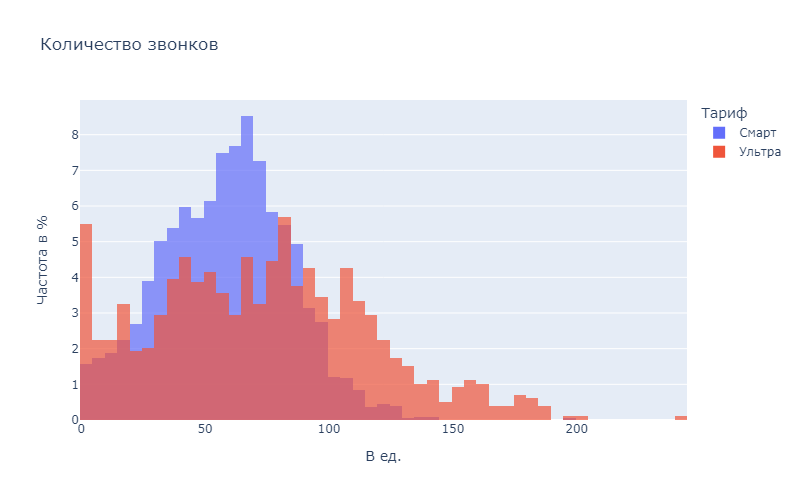

In [4]:
fig = px.histogram(data_frame=df, 
             x='calls', 
             color='is_ultra', 
             histnorm='percent',
             barmode='overlay',
             title='Количество звонков',
             opacity=0.7,
             width = 800)
fig.update_layout(yaxis={"title":"Частота в %"}, 
                  xaxis={'title':"В ед."},
                 legend={'title':'Тариф'})
newnames = {'0':'Смарт', '1': 'Ультра'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show("png")

Заметно, что число звонков у пользователей тарифа "Смарт" более "усредненное" - доля пользователей, совершающих как менее 20, так и более 90 звонков в месяц ниже, чем у пользователей тарифа "Ультра". При этом доля пользователей тарифа "Смарт" с числом звонков более 130 пренебрежимо мала, в то время как среди клиентов тарифа "Ультра" показатель составляет ок. 10%.

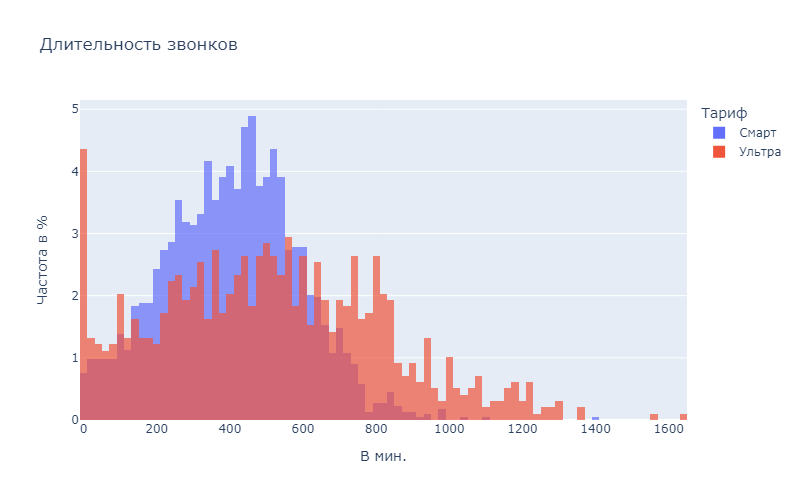

In [5]:
fig = px.histogram(data_frame=df, 
             x='minutes', 
             color='is_ultra', 
             histnorm='percent',
             barmode='overlay',
             title='Длительность звонков',
             opacity=0.7,
             width = 800)
fig.update_layout(yaxis={"title":"Частота в %"}, 
                  xaxis={'title':"В мин."},
                 legend={'title':'Тариф'})
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show("png")

Распределения аналогичны числу звонков в месяц: среди пользователей тарифа "Ультра" выше доля тех, кто тратит менее 130 мин. в месяц, но также и тех, кто тратит более 630 мин. в месяц, причем "правый хвост" распределения "Ультра" значительно длиннее и толще.

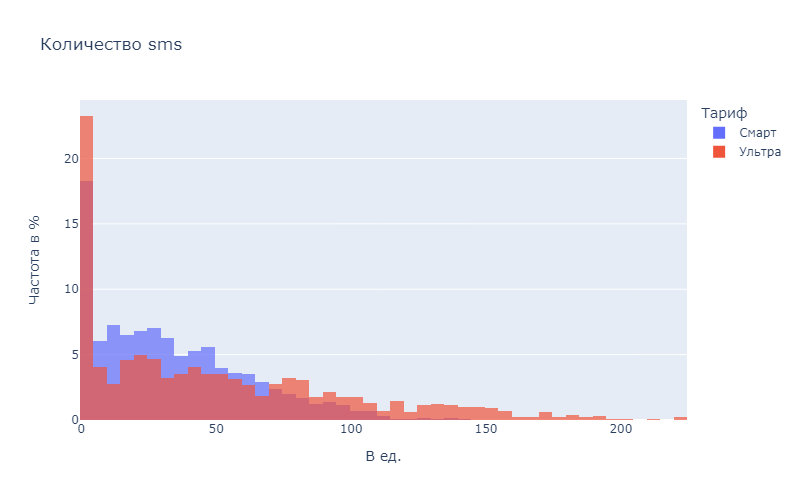

In [6]:
fig = px.histogram(data_frame=df, 
             x='messages', 
             color='is_ultra', 
             histnorm='percent',
             barmode='overlay',
             title='Количество sms',
             opacity=0.7,
             width = 800)
fig.update_layout(yaxis={"title":"Частота в %"}, 
                  xaxis={'title':"В ед."},
                 legend={'title':'Тариф'})
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show("png")

Схожая ситуация.

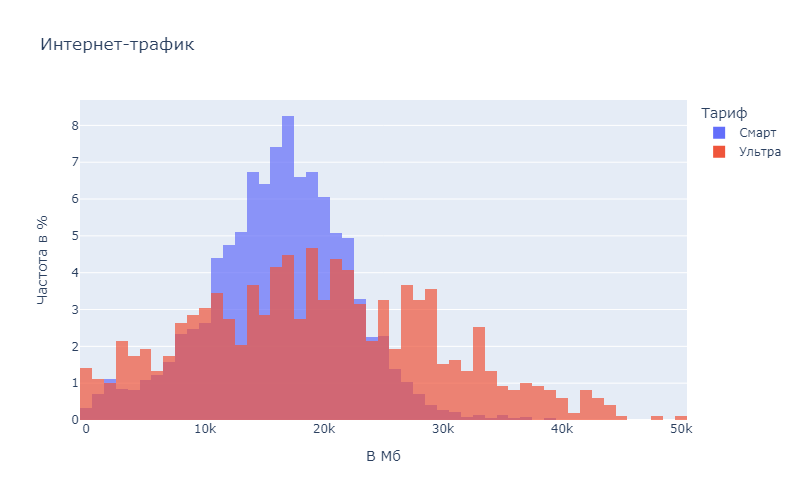

In [7]:
fig = px.histogram(data_frame=df, 
             x='mb_used', 
             color='is_ultra', 
             histnorm='percent',
             barmode='overlay',
             title='Интернет-трафик',
             opacity=0.7,
             width = 800)
fig.update_layout(yaxis={"title":"Частота в %"}, 
                  xaxis={'title':"В Мб"},
                 legend={'title':'Тариф'})
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show("png")

Аналогичные тренды.

**Вывод**

Исходный датасет содержит ок. 3,2 тыс. объектов, пропусков в данных нет, поэтому предобработка не требуется. 

Целевой признак распределен неравномерно: на тариф "Ультра" приходится только 30% всех объектов в выборке. Соответственно, при разделении датасета на выборки нужна стратификация для сохранения репрезентативности.

Поведение пользователей тарифа "Смарт" более "усредненное" по сравнению с пользователями тарифа "Ультра" - среди последних выше доля пользователей как с предельно низким числом звонков, смс и т.п., так и с крайне высокими значениями признаков. При этом явных аномальных значений признаков в датасете не наблюдается.

## Формирование выборок

Разделим исходный датасет на обучающую, валидационную и тестовую выборки в отношении 60% : 20% : 20%. Т.к. целевой признак распределен по классам неравномерно, стратифицируем выборки по целевому признаку.

In [8]:
# Формируем массивы признаков и целевого признака:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']
# Отделяем тестовую выборку:
features_inter, features_test, target_inter, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.2, 
                                                                            random_state = 1104, 
                                                                            stratify=target)
# Оставшуюся часть датасета делим на обучающую и валидационную выборки:
features_train, features_valid, target_train, target_valid = train_test_split(features_inter, 
                                                                            target_inter, 
                                                                            test_size = 0.25, 
                                                                            random_state = 1104, 
                                                                            stratify=target_inter)
# Т.к. 20% тестовой выборки уже были отделены, валидационная относится к обучаюющей как 1 к 4
print('Кол-во объектов в обучающей выборке:', features_train.shape[0])
print('Кол-во объектов в валидационной выборке:', features_valid.shape[0])
print('Кол-во объектов в тестовой выборке:', features_test.shape[0])

Кол-во объектов в обучающей выборке: 1928
Кол-во объектов в валидационной выборке: 643
Кол-во объектов в тестовой выборке: 643


## Исследование моделей

Используем три модели: дерево решений, случайный лес и логистическая регрессия. В каждом из типов моделей найдем лучшую в зависимости от гиперпараметров на основании критерия accuracy.

### Дерево решений

Выберем модель, выдающую наибольшую точность предсказаний на валидационной выборке, в зависимости от максимальной глубины и критерия выбора. Т.к. на больших значениях глубины модель склонна к переобучению, ограничим поле возможных значений от 1 до 8.

Accuracy лучшей модели на валидационной выборке - 0.80248833592535 при глубине 6 (критерий entropy)


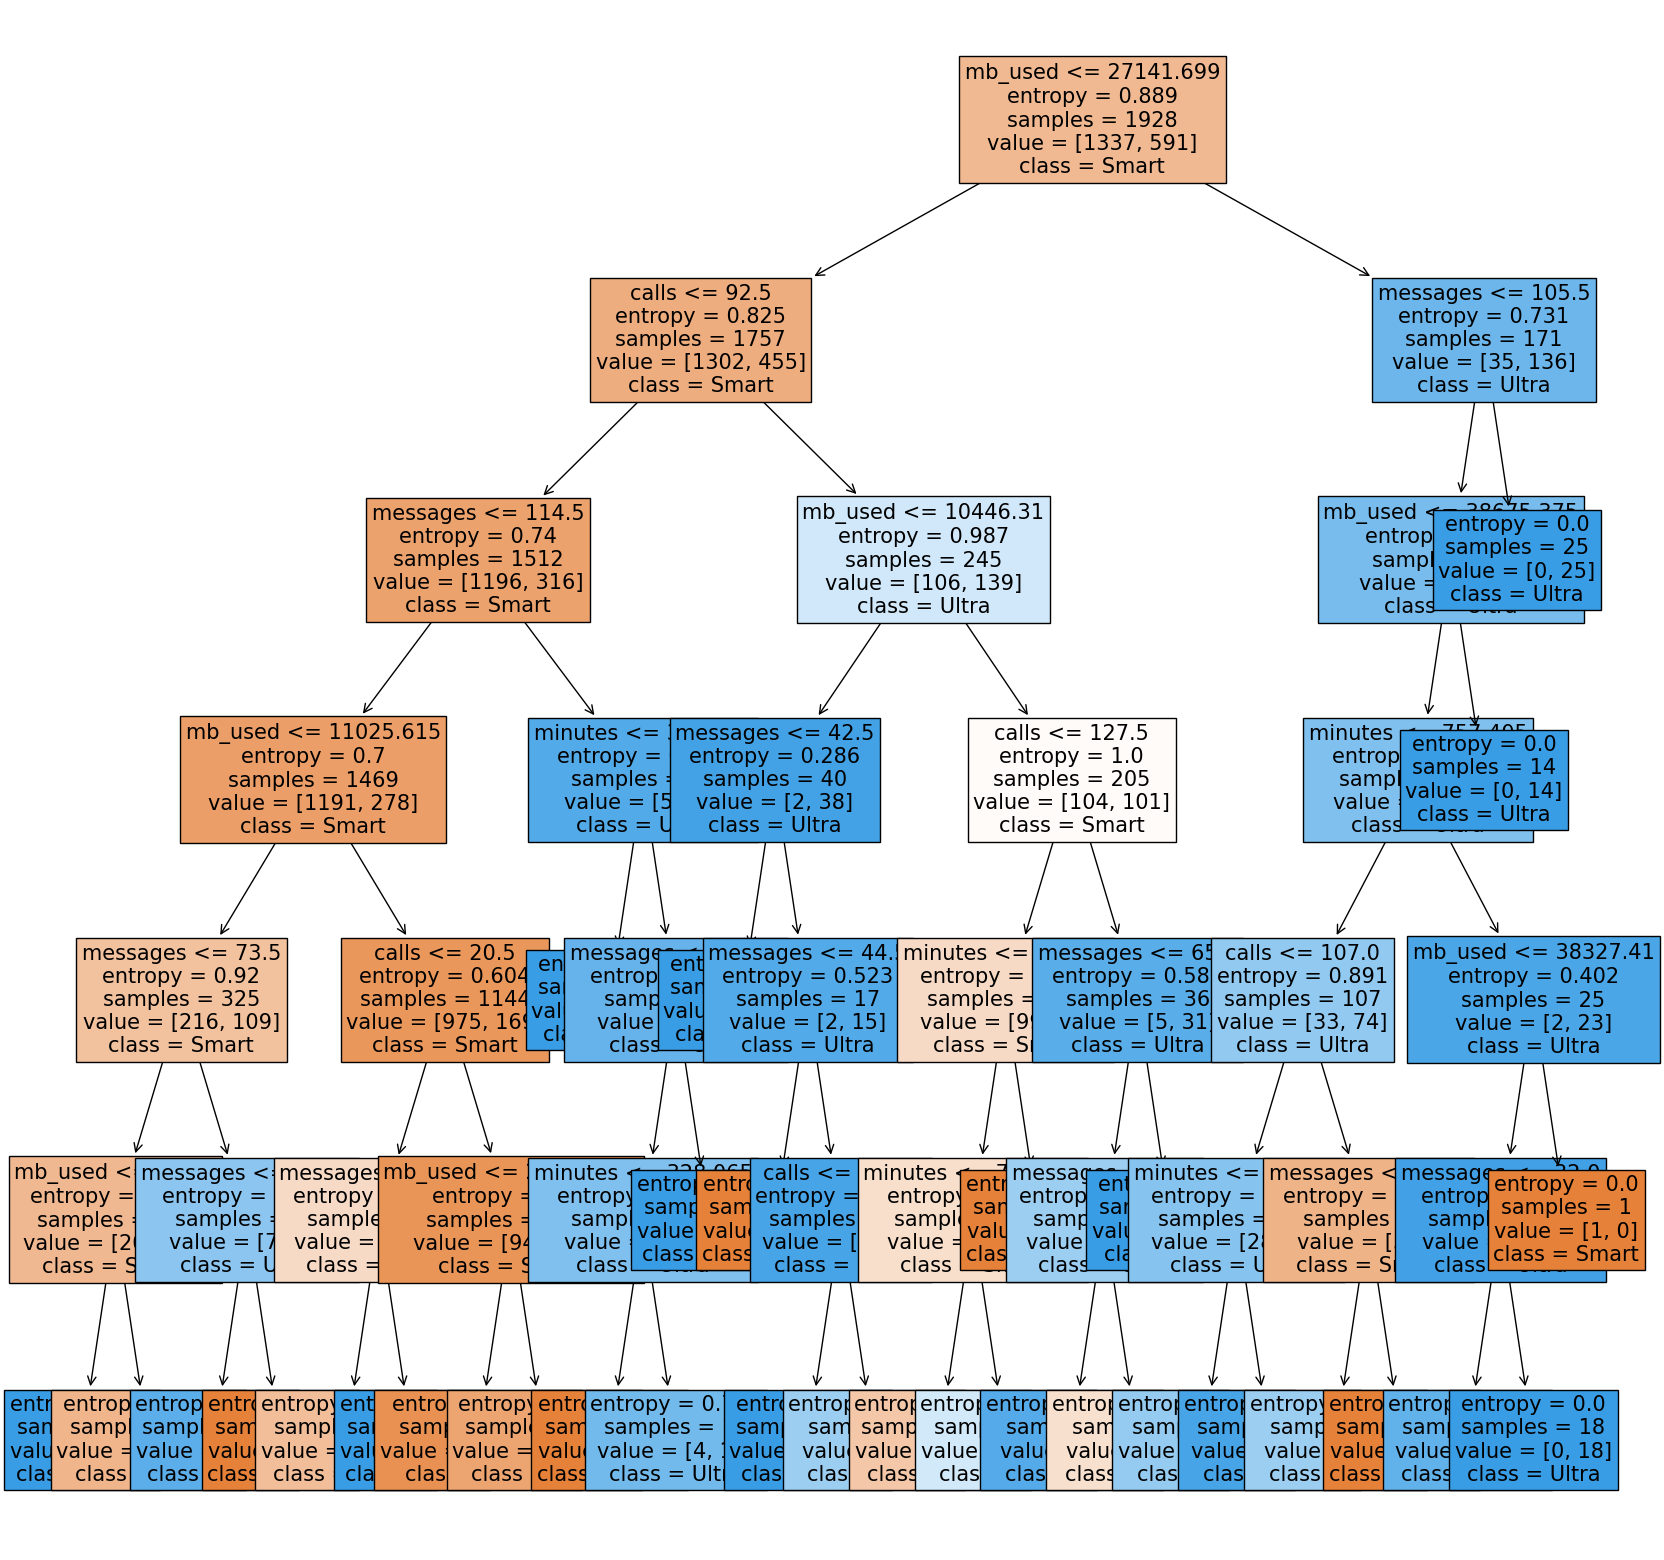

In [9]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_crit_tree = ''

# Обучим модель дерева решений, меняя гиперпараметры глубины и критерия отбора:
for crit in ['gini', 'entropy']:
    for depth in range(1, 9):
        model = DecisionTreeClassifier(random_state=1104, max_depth=depth, criterion=crit) 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        if result > best_result_tree:
            best_model_tree = model
            best_result_tree = result
            best_depth_tree = depth
            best_crit_tree = crit
        
print("Accuracy лучшей модели на валидационной выборке - {0} при глубине {1} (критерий {2})".
      format(best_result_tree, best_depth_tree, best_crit_tree))

# Визуализация модели:
fig = plt.figure(figsize=(20,20)) # для увеличения размера картинки
_ = plot_tree(best_model_tree, 
               feature_names=features_train.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15)

### Случайный лес

Выберем модель, выдающую наибольшую точность предсказаний на валидационной выборке, в зависимости от максимальной глубины дерева, числа деревьев и критерия выбора. Как и в случае с деревом решений, ограничим глубину интервалом от 1 до 8. Число деревьев ограничим значениями от 5 до 50 с шагом в 5. 

In [10]:
%%time 
# добавила после 1го ревью

best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
best_crit_forest = 0

# Обучим модель случайного леса, меняя гиперпараметры глубины дерева, числа деревьев и критерия отбора:
for crit in ['gini', 'entropy']:
    for est in range(5, 51, 5):
        for depth in range(1, 9):
            model = RandomForestClassifier(random_state=1104, max_depth=depth, criterion=crit, n_estimators=est) 
            model.fit(features_train, target_train) 
            result = model.score(features_valid, target_valid) 
            if result > best_result_forest:
                best_model_forest = model
                best_result_forest = result
                best_depth_forest = depth
                best_est_forest = est
                best_crit_forest = crit
        
print("Accuracy лучшей модели на валидационной выборке - {0} при глубине {1} и числе деверьев {2} (критерий {3})".
      format(best_result_forest, best_depth_forest, best_est_forest, best_crit_forest))

Accuracy лучшей модели на валидационной выборке - 0.8258164852255054 при глубине 8 и числе деверьев 20 (критерий entropy)
CPU times: total: 14.3 s
Wall time: 14.3 s


### Логистическая регрессия

Выберем модель, выдающую наибольшую точность предсказаний на валидационной выборке, в зависимости от используемого алгоритма оптимизации.

In [11]:
best_model_logreg = None
best_result_logreg = 0
best_crit_logreg = ''

warnings.filterwarnings('ignore')
# Обучим модель логистической регрессии, меняя гиперпараметр алгоритма оптимизации:
for crit in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(random_state=1104, solver=crit) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result_logreg:
        best_model_logreg = model
        best_result_logreg = result
        best_crit_logreg = crit
        
print("Accuracy лучшей модели на валидационной выборке - {0} (алгоритм {1})".
      format(best_result_logreg, best_crit_logreg))

Accuracy лучшей модели на валидационной выборке - 0.7589424572317263 (алгоритм newton-cg)


### Вывод

На валидационной выборке наибольший показатель accuracy достигает модель случайного леса (0.826). Примемлемая точность также у дерева решений (0.802), в то время как лучший показатель accuracy среди вариантов логистической регрессии едва превысил 0.75 (0.758). Таким образом, выбираем случайный лес как модель с наибольшей предсказательной точностью.

Теперь проверим выбранную модель на тестовой выборке.

## Проверка на тестовой выборке

Найдем accuracy выбранной ранее модели на тестовой выборке:

In [12]:
print('Accuracy для случайного леса на тестовой выборке:', best_model_forest.score(features_test, target_test))

Accuracy для случайного леса на тестовой выборке: 0.8258164852255054


Предсказательная точность модели не изменилась на тестовой выборке по сравнению с валидационной (0.826), при этом она выше порогового значения 0.75. Таким образом, для поставленной задачи выбора тарифа на основе поведения клиента оптимальной является модель **случайного леса**.

##  Проверка моделей на адекватность

Расчитаем accuracy модели, генерирующей ответы случайным образом, и сравним с предсказательной точностью моделей:

$accuracy = \frac{N_1\;*\;Share_1\;+\;N_0\;*\;Share_0}{N}\;=\;\frac{0.3\;*\;N\;*\;Share_1\;+\;0.7\;*\;N\;*\;Share_0}{N}\;=\;0.3\;*\;Share_1\;+\;0.7\;*Share_0\;=\;0.3\;*\;0.5\;+\;0.7\;*\;0.5\;=\;0.5$

Где $$N_1(_0)\;-\;число\;ответов\;для\;тарифа\;"Ультра"\;("Смарт"),$$ $$Share_1(_0)\;-\;доля\;правильных\;ответов\;для\;тарифа\;"Ультра"\;("Смарт"),$$ $$N\;-\;общее\;число\;ответов.$$

Доля правильных ответов независима и составляет 0.5 для случайно генерируемого ответа. 

При этом модель, пресказывающая нули (тариф "Смарт") независимо от признаков, покажет accuracy по числу нулей в исходной выборке, т.е. ок. 0.694. Выбранная модель превосходит это значение (accuracy 0.826).

## Общий вывод

Цель проекта состояла в построении модели, позволяющей определить наиболее подходящий тариф ("Смарт" или "Ультра") в зависимости от потребностей пользователя с точностью не менее 75%. Для обучения и тестирования модели доступны данные клиентов, уже пользующихся данными тарифами (ок. 3,2 тыс. объектов).

Объекты исходной выборки были распределены по классам неравномерно: на тариф "Ультра" пришлось ок. 30%, на "Смарт" - ок. 70%. В связи с этим выборка была разделена на обучающую (60% объектов), валидационную (20%) и тестовую (20%) стратифицированно по целевому признаку.

Для дальнейшего обучения были выбраны три типа моделей, позволяющих решать задачи классификации - дерево решений, случайный лес и логистическая регрессия. Было обучено несколько моделей каждого типа в зависимости от гиперпараметров:

* для дерева решений - максимальная глубина и критерий выбора;
* для случайного леса -максимальная глубина дерева, количество деревьев и критерий выбора;
* для логистической регресси - алгоритм оптимизации.

В каждом типе моделей была выбрана одна с наибольшей предсказательной точностью на основе валидационной выборки. Все три модели показали accuracy выше 0.75, лидером стала модель случайного леса (0.826).Предсказательная точность модели не изменилась на тестовой выборке.

Таким образом, для определелия тарифа на основе пользовательского поведения предлагается использовать *модель случайного леса с максимальной глубиной дерева 8 и количеством деревьев 20 (критерий - энтропия)*.